In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm #library to make a progress bar when doing long for loops
from scipy.optimize import curve_fit #for forcing curve fit
import time #for testing efficiency of code

import warnings
warnings.filterwarnings('ignore') #suppressed normal warnings (disable this if something stops working)

In [43]:
#Import data for processing

#filename = "./20-08-2020/SMC_4rose_2.xlsx"
filename = "./24-08-2020/SMC_randwalk.xlsx"
data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])

while data.iloc[0]['rb1z']==0.0:
    data = data.drop(0)
    data.index-=1
      
data.iloc[0]['rb1z']        


96.8733212376683

In [44]:
#calculate robot position at each point

#calculate the center of the robot
Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
       data['rb1y']*(data['rb4x']-data['rb6x']) +
       data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters


x_mid = (data['rb1x']+data['rb8x'])/2./1000.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
y_mid = (data['rb1y']+data['rb8y'])/2./1000.+Cdet[0]/(2.*Adet[0])/1000.

#rotate desired position to be in line with robot
#xd_rot =data['xd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-data['yd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
#yd_rot =data['yd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+data['xd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
xd_rot = data['xd']
yd_rot = data['yd']


xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))


#set robot initial position to the origin
#x_r = x_r+Bdet[0]/(2.*Adet[0])/1000. #robot position x in meters starting at origin
#y_r = y_r+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters  starting at origin
theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0

In [45]:
#cast robot info into a new dataframe

pdata = pd.DataFrame()
pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
pdata.insert(2, "y_r", yr_rot,True)
pdata.insert(3, "theta_r", theta_r,True)

pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
pdata.insert(5, "y_d", yd_rot,True)
pdata.insert(6, "theta_d", data['thetad'],True)

pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
pdata.insert(8,'e_y', pdata['y_r']-pdata['y_d'])
pdata.insert(9,'e_theta', pdata['theta_r']-pdata['theta_d'])

pdata.insert(10,'e_x_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(11,'e_y_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(12,'e_theta_nt',np.zeros(len(pdata['x_r'])))

#for i in range (1000,len(pdata['theta_r'])): #use to drop the last x amount of data
#    pdata = pdata.drop(i)

#for i in range(0, 200):
#    pdata = pdata.drop(i)

In [46]:
Chopnum=1
Min_index = 0

for i in tqdm(range(Chopnum, len(pdata['x_r'])-Chopnum-1)): #Minimize total RMSE
    #print(i)
    temp = np.sqrt(np.square(pdata.at[i,'x_r']-pdata[i-Chopnum:i+Chopnum]['x_d']) #Using ABS is about twice as fast, but gives a different answer
               + np.square(pdata.at[i,'y_r']-pdata[i-Chopnum:i+Chopnum]['y_d']) 
               + np.square(pdata.at[i,'theta_r']-pdata[i-Chopnum:i+Chopnum]['theta_d']))
    Min_index= np.argmin(temp)
    
    pdata.iat[i,10] = (pdata.iat[i,1]-pdata.iat[Min_index,4])
    pdata.iat[i,11] = (pdata.iat[i,2]-pdata.iat[Min_index,5])
    pdata.iat[i,12] = (pdata.iat[i,3]-pdata.iat[Min_index,6])

    
pdata.drop(index=np.linspace(0,Chopnum,num=Chopnum+1,dtype=int),inplace=True)
pdata.drop(index=np.linspace(len(pdata['theta_r'])-Chopnum,len(pdata['theta_r']),num=Chopnum+1,dtype=int),inplace=True)
pdata.reset_index(inplace=True, drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 653.21it/s]


In [39]:
#Do additional trimming here, don't forget to fix the indexing after!!!!
for i in range(0, 200):
    pdata = pdata.drop(i)
pdata.index-=200

KeyError: 'labels [45] not contained in axis'

In [47]:
RMSE_x = np.sqrt(sum(pdata['e_x']**2)/len(pdata['e_x']))
RMSE_y = np.sqrt(sum(pdata['e_y']**2)/len(pdata['e_y']))
RMSE_theta = np.sqrt(sum(pdata['e_theta']**2)/len(pdata['e_theta']))

RMSE_x_nt = np.sqrt(sum(pdata['e_x_nt']**2)/len(pdata['e_x']))
RMSE_y_nt = np.sqrt(sum(pdata['e_y_nt']**2)/len(pdata['e_y']))
RMSE_theta_nt = np.sqrt(sum(pdata['e_theta_nt']**2)/len(pdata['e_theta']))

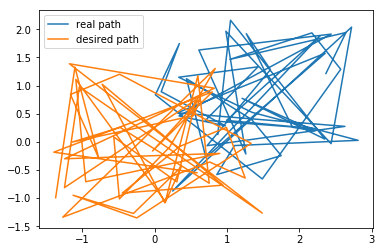

In [48]:
ax = plt.subplot(1,1,1)
#pdata['x_d'][0] = 0
ax.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
ax.legend(['real path', 'desired path'])
#ax.plot(pdata.iloc[0]['x_d'],pdata.iloc[0]['y_d'],linewidth=6)
#print(pdata.iloc[0]['x_d'])
#print(pdata.iloc[0]['y_d'])
#print(np.arctan2(y_mid[0],x_mid[0])*180/np.pi)
#plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#plt.plot(pdata[0]['x_d'],pdata[0]['y_d'])
plt.show()

In [38]:
print(RMSE_x)
print(RMSE_y)
print(RMSE_theta)

print(RMSE_x_nt)
print(RMSE_y_nt)
print(RMSE_theta_nt)

0.7528525676430526
1.5101700633729493
4.281749618265927
0.9247465564341935
1.4388817809538408
2.867307413308875


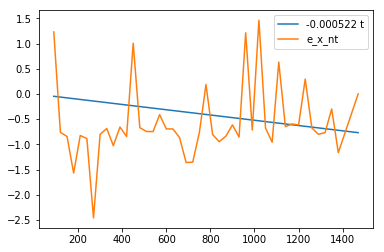

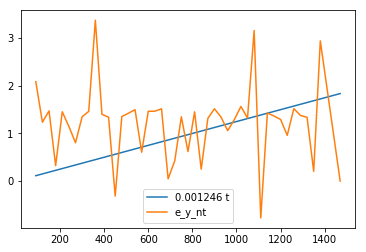

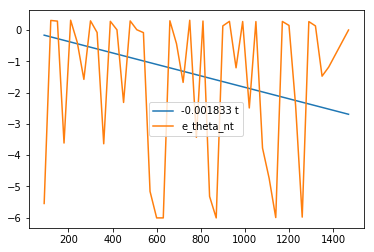

'\n\nm_x,b_x = np.polyfit(pdata[\'globaltime\'], pdata[\'e_x_nt\'], 1) # Come up with linear fits for drift (b!=0)\nm_y,b_y = np.polyfit(pdata[\'globaltime\'], pdata[\'e_y_nt\'], 1)\nm_theta,b_theta = np.polyfit(pdata[\'globaltime\'], pdata[\'e_theta_nt\'], 1)\n\nplt.plot(pdata[\'globaltime\'],m_x*pdata[\'globaltime\']+b_x,label=("%f t %f" % (m_x,b_x)))\nplt.plot(pdata[\'globaltime\'],pdata[\'e_x_nt\'])\nplt.legend()\nplt.show()\n\nplt.plot(pdata[\'globaltime\'],m_y*pdata[\'globaltime\']+b_y,label=("%f t %f" % (m_y,b_y)))\nplt.plot(pdata[\'globaltime\'],pdata[\'e_y_nt\'])\nplt.legend()\nplt.show()\n\nplt.plot(pdata[\'globaltime\'],m_theta*pdata[\'globaltime\']+b_theta,label=("%f t %f" % (m_theta,b_theta)))\nplt.plot(pdata[\'globaltime\'],pdata[\'e_theta_nt\'])\nplt.legend()\nplt.show()'

In [39]:
def fit_func(x, a): #Come up with linear fits for drift (b=0)
    return a*x

m_x = curve_fit(fit_func, pdata['globaltime'], pdata['e_x_nt'])[0]
m_y = curve_fit(fit_func, pdata['globaltime'], pdata['e_y_nt'])[0]
m_theta = curve_fit(fit_func, pdata['globaltime'], pdata['e_theta_nt'])[0]

plt.plot(pdata['globaltime'],m_x*pdata['globaltime'],label=("%f t" % (m_x)))
plt.plot(pdata['globaltime'],pdata['e_x_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_y*pdata['globaltime'],label=("%f t" % (m_y)))
plt.plot(pdata['globaltime'],pdata['e_y_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_theta*pdata['globaltime'],label=("%f t" % (m_theta)))
plt.plot(pdata['globaltime'],pdata['e_theta_nt'])
plt.legend()
plt.show()

'''

m_x,b_x = np.polyfit(pdata['globaltime'], pdata['e_x_nt'], 1) # Come up with linear fits for drift (b!=0)
m_y,b_y = np.polyfit(pdata['globaltime'], pdata['e_y_nt'], 1)
m_theta,b_theta = np.polyfit(pdata['globaltime'], pdata['e_theta_nt'], 1)

plt.plot(pdata['globaltime'],m_x*pdata['globaltime']+b_x,label=("%f t %f" % (m_x,b_x)))
plt.plot(pdata['globaltime'],pdata['e_x_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_y*pdata['globaltime']+b_y,label=("%f t %f" % (m_y,b_y)))
plt.plot(pdata['globaltime'],pdata['e_y_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_theta*pdata['globaltime']+b_theta,label=("%f t %f" % (m_theta,b_theta)))
plt.plot(pdata['globaltime'],pdata['e_theta_nt'])
plt.legend()
plt.show()'''

In [40]:
pdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']) #calculate adjusted errors (b=0)
pdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime'])
pdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime'])

'''

pdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']-b_x) #calculate adjusted errors (b!=0)
pdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime']-b_y)
pdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime']-b_theta)'''

"\n\npdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']-b_x) #calculate adjusted errors (b!=0)\npdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime']-b_y)\npdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime']-b_theta)"

In [41]:
RMSE_x_adj=np.sqrt(sum(pdata['e_x_adj']**2)/len(pdata['e_x']))
RMSE_y_adj=np.sqrt(sum(pdata['e_y_adj']**2)/len(pdata['e_x']))
RMSE_theta_adj=np.sqrt(sum(pdata['e_theta_adj']**2)/len(pdata['e_x']))

print(RMSE_x_adj)
print(RMSE_y_adj)
print(RMSE_theta_adj)

0.8118218536330315
0.9774432625632172
2.410022590821611


In [42]:
'''SMC
0.007911945788985115
0.00863649489580498
0.0048623659373607546


FLPID
0.03140264843045096
0.03267528114119598
0.025296186957973775

'''

'SMC\n0.007911945788985115\n0.00863649489580498\n0.0048623659373607546\n\n\nFLPID\n0.03140264843045096\n0.03267528114119598\n0.025296186957973775\n\n'

In [340]:
tic = time.perf_counter()
pdata.drop(index=np.linspace(0,100,num=101,dtype=int),inplace=True)
toc = time.perf_counter()
pdata.reset_index(inplace=True,drop=True)
print(toc-tic)


tic = time.perf_counter()
for i in range(0, Chopnum):
    pdata = pdata.drop(i) 
toc = time.perf_counter()
pdata.reset_index(inplace=True,drop=True)
print(toc-tic)
print(pdata)

0.0015965000000051077
0.05842710000001716
      level_0  index  globaltime       x_r       y_r   theta_r       x_d  \
0         608    709   14.458895 -0.144069 -0.967167  0.003758 -0.056271   
1         609    710   14.481654 -0.142256 -0.968771  0.004161 -0.053935   
2         610    711   14.504412 -0.140359 -0.969978  0.003085 -0.051595   
3         611    712   14.527394 -0.136618 -0.973376  0.003785 -0.049229   
4         612    713   14.551163 -0.134784 -0.974881  0.003941 -0.046777   
5         613    714   14.573231 -0.133096 -0.976611  0.004248 -0.044498   
6         614    715   14.596228 -0.131093 -0.977944  0.003965 -0.042119   
7         615    716   14.619957 -0.129145 -0.979474  0.005073 -0.039662   
8         616    717   14.642448 -0.127090 -0.981023  0.005653 -0.037329   
9         617    718   14.664894 -0.123211 -0.983721  0.005578 -0.034999   
10        618    719   14.686868 -0.121521 -0.984954  0.005934 -0.032715   
11        619    720   14.710587 -0.119524 -0.

In [339]:
pdata.drop(0,inplace=True,axis=0)
pdata.reset_index(inplace=True,drop=True)
print(pdata)

      level_0  index  globaltime       x_r       y_r   theta_r       x_d  \
0         407    508   10.189139 -0.213070 -0.314473  0.002611 -0.257743   
1         408    509   10.205438 -0.214831 -0.318010  0.001962 -0.258332   
2         409    510   10.229066 -0.216226 -0.321362  0.001675 -0.259164   
3         410    511   10.247821 -0.217569 -0.324912  0.001613 -0.259806   
4         411    512   10.265185 -0.219041 -0.328532  0.001666 -0.260386   
5         412    513   10.284446 -0.220459 -0.332088  0.002233 -0.261012   
6         413    514   10.304742 -0.221926 -0.335542  0.001669 -0.261654   
7         414    515   10.330055 -0.223531 -0.339093  0.002295 -0.262427   
8         415    516   10.347861 -0.224850 -0.342470  0.003296 -0.262953   
9         416    517   10.364987 -0.226063 -0.345623  0.004925 -0.263446   
10        417    518   10.384803 -0.227210 -0.348480  0.006528 -0.263998   
11        418    519   10.404482 -0.228239 -0.351421  0.008377 -0.264529   
12        41

In [11]:
pdata

,globaltime,x_r,y_r,theta_r,x_d,y_d,theta_d,e_x,e_y,e_theta,e_x_nt,e_y_nt,e_theta_nt
0,30.011010,0.000000,0.000000,0.000000,0.618138,-1.404501,1.661538,-0.618138,1.404501,-1.661538,0.0,0.0,0.0
1,60.019176,0.000000,0.000000,0.000000,-1.361486,-1.208605,4.940747,1.361486,1.208605,-4.940747,0.0,0.0,0.0
2,90.024619,0.872279,0.131751,-2.177388,0.584486,-0.548702,5.701332,0.287793,0.680453,-7.878721,0.0,0.0,0.0
3,120.031512,1.049138,2.158667,1.024272,-1.396662,-0.183767,2.289351,2.445800,2.342433,-1.265079,0.0,0.0,0.0
4,150.051927,2.353918,0.047961,-0.165409,0.796550,0.885600,1.121236,1.557367,-0.837639,-1.286645,0.0,0.0,0.0
5,180.057672,1.208918,0.771880,-4.064141,-0.030707,-0.163241,3.877878,1.239625,0.935121,-7.942019,0.0,0.0,0.0
6,210.074634,2.214826,0.195751,0.397592,0.628094,0.764060,1.656150,1.586732,-0.568309,-1.258558,0.0,0.0,0.0
7,240.082447,1.906927,0.258214,-0.308343,0.539108,0.465294,0.975670,1.367819,-0.207080,-1.284014,0.0,0.0,0.0
8,270.086017,1.267001,1.920410,-2.173424,-1.143007,-0.004908,5.758464,2.410008,1.925318,-7.931888,0.0,0.0,0.0
9,300.089477,1.601329,1.281239,0.065071,-0.478843,0.255803,1.342872,2.080172,1.025435,-1.277801,0.0,0.0,0.0
